In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings

warnings.filterwarnings("ignore")
import logging

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow import expand_dims
from tensorflow.keras.losses import MeanAbsolutePercentageError
import tensorflow

from datetime import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot

/home/amirel/.pyenv/versions/3.8.12/envs/time_series/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-09-13 14:18:47.025962: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-13 14:18:47.138332: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-13 14:18:47.142228: W tensorflow/stream_executor/p

# LSTM 2017-2018


In [2]:
df = pd.read_csv('../../AltInt/Inflation_prediction/raw_data/final_df.csv', index_col=0)


In [3]:
df.index = pd.to_datetime(df.index)
df

,Brent_Crude_GBP,WTI_Crude_GBP,GBP Curncy,GBPEUR Curncy,UKX Index,SPX Index,SX5E Index,Natural_Gas,CPI,RPI,GBP_IRS_2y,GBP_IRS_10y,Nationwide_HPI,RPI YOY
Date,,,,,,,,,,,,,,
2009-01-01,30.903838,33.424333,1.479027,1.099905,4308.390000,596.071497,2135.982324,12.472805,84.9,210.1,2.122545,3.757500,300.2,0.142993
2009-02-01,29.393166,33.617553,1.492643,1.120824,4232.114762,570.410394,2020.716905,9.467866,85.6,211.4,2.129905,3.798333,294.7,0.000000
2009-03-01,31.733352,36.826152,1.494241,1.097877,4107.840909,566.393975,2029.160819,8.064295,85.8,211.3,2.142045,3.872500,301.1,-0.377181
2009-04-01,33.990786,36.012519,1.511936,1.125327,4259.890500,588.042125,2119.383029,7.762397,86.0,211.5,2.143250,3.935500,302.9,-1.168224
2009-05-01,37.524515,38.801542,1.561252,1.131686,4434.719500,582.718727,2164.120107,7.757394,86.4,212.8,2.031900,3.917500,307.2,-1.069270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-01,89.748267,85.128666,1.247484,1.178074,7472.767778,3274.256696,3179.554466,81.073170,120.8,337.1,2.538121,2.240542,538.4,11.659490
2022-06-01,95.251442,87.836565,1.233611,1.167758,7238.188421,3172.340166,3058.969505,96.746393,121.8,340.0,2.933563,2.626558,541.8,11.842105
2022-07-01,85.363871,80.415504,1.231479,1.184589,7303.865263,3298.689210,3082.959231,128.688654,122.5,343.2,2.700779,2.302258,541.0,12.340426


In [4]:
#rpi_lag = pd.read_csv('RPI_lagged.csv')


In [5]:
#rpi_lag

In [6]:
# rpi_lag = rpi_lag.rename({'Date CO1 Comdty': 'Date'}, axis=1)
# rpi_lag = rpi_lag.set_index('Date')


In [7]:
#rpi_lag.index = pd.to_datetime(rpi_lag.index)

In [8]:
#rpi_lag

In [9]:
#new_df = df.join(rpi_lag)

In [10]:
#new_df

In [5]:
# X = new_df.drop(columns = ['RPI', 'CPI', 'RPI YOY'])
# y = new_df['RPI']

X = df.drop(columns = ['RPI', 'CPI', 'RPI YOY'])
y = df['RPI']

In [6]:
X[72:96]

,Brent_Crude_GBP,WTI_Crude_GBP,GBP Curncy,GBPEUR Curncy,UKX Index,SPX Index,SX5E Index,Natural_Gas,GBP_IRS_2y,GBP_IRS_10y,Nationwide_HPI
Date,,,,,,,,,,,
2015-01-01,32.818125,31.737054,1.516177,1.336264,6641.765238,1339.503656,2495.664852,13.099203,0.858274,1.684729,375.9
2015-02-01,38.343255,32.759207,1.533386,1.362371,6746.840476,1356.232800,2536.801725,13.938965,0.952887,1.856450,375.0
2015-03-01,37.866261,31.635113,1.503677,1.377568,6791.140000,1380.431518,2615.694574,13.821672,0.947216,1.783045,377.9
2015-04-01,40.409377,35.572047,1.512909,1.386036,6886.650952,1381.813784,2620.084413,13.690119,0.923663,1.811432,385.1
2015-05-01,42.505052,36.186768,1.543548,1.384014,6864.994500,1360.216539,2568.111738,13.123988,1.009908,1.971630,389.3
2015-06-01,41.067582,35.885473,1.552386,1.385524,6687.803500,1340.919813,2507.691659,13.023503,1.061182,2.089545,389.1
2015-07-01,36.726002,31.989864,1.545617,1.402913,6625.526087,1353.218881,2518.626151,13.169073,1.119989,2.051104,390.2
2015-08-01,31.196110,29.152671,1.545248,1.376957,6402.255000,1311.027051,2434.955959,12.478583,1.085050,1.958367,389.6
2015-09-01,31.774855,30.721787,1.527609,1.364657,6280.524348,1302.101893,2375.712634,12.595702,1.004023,1.908904,390.2


In [7]:
X_train, y_train = X[:72], y[:72]
X_val, y_val = X[72:96], y[72:96]
X_test, y_test = X[96:108], y[96:108]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((72, 11), (72,), (24, 11), (24,), (12, 11), (12,))

In [8]:
y_train_x = expand_dims(y_train, -1)
y_train_x = expand_dims(y_train_x, -1)

y_train_x.shape

2022-09-13 14:19:46.187233: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-13 14:19:46.187983: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-13 14:19:46.188030: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-S0KUROGM): /proc/driver/nvidia/version does not exist
2022-09-13 14:19:46.193250: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorShape([72, 1, 1])

In [9]:
y_val_x = expand_dims(y_val, -1)
y_val_x = expand_dims(y_val_x, -1)

In [10]:
y_val_x.shape

TensorShape([24, 1, 1])

In [11]:
X_test_x = expand_dims(X_test, -2)

In [12]:
X_test_x.shape

TensorShape([12, 1, 11])

In [13]:
X_train_x = expand_dims(X_train, -2)
X_train_x.shape

TensorShape([72, 1, 11])

In [14]:
X_val_x = expand_dims(X_val, -2)
X_val_x.shape

TensorShape([24, 1, 11])

In [15]:
lr_scheduler = ExponentialDecay(initial_learning_rate=0.001, decay_steps= 10_000, decay_rate=0.7)
adam = Adam(learning_rate=lr_scheduler)
es = EarlyStopping(patience=50, restore_best_weights=True)

In [16]:
normalizer = Normalization()
normalizer.adapt(X_train_x)

model1 = Sequential()
model1.add(normalizer)

model1.add(LSTM(units = 100, activation='tanh', return_sequences = True))
model1.add(LSTM(units = 50 , activation='tanh', return_sequences = False))

model1.add(Flatten())

model1.add(Dense(100,activation =  'relu'))
model1.add(Dense(50,activation =  'relu'))
model1.add(Dense(25,activation =  'relu'))

model1.add(Dense(1, activation = 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, None, 11)         23        
 n)                                                              
                                                                 
 lstm (LSTM)                 (None, None, 100)         44800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 100)               5100      
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                        

In [17]:
mape = MeanAbsolutePercentageError()

In [18]:
model1.compile(loss= mape, optimizer= adam, metrics=['mape'])

In [19]:
model1.fit(X_train_x, y_train,batch_size = 32, validation_data=(X_val_x, y_val), epochs=10000, callbacks = (es))

Epoch 1/10000
3/3 [==============================] - 3s 319ms/step - loss: 99.9950 - mape: 99.9950 - val_loss: 99.9775 - val_mape: 99.9775
Epoch 2/10000
3/3 [==============================] - 0s 25ms/step - loss: 99.9762 - mape: 99.9762 - val_loss: 99.9576 - val_mape: 99.9576
Epoch 3/10000
3/3 [==============================] - 0s 28ms/step - loss: 99.9527 - mape: 99.9527 - val_loss: 99.9313 - val_mape: 99.9313
Epoch 4/10000
3/3 [==============================] - 0s 25ms/step - loss: 99.9228 - mape: 99.9228 - val_loss: 99.8966 - val_mape: 99.8966
Epoch 5/10000
3/3 [==============================] - 0s 24ms/step - loss: 99.8838 - mape: 99.8838 - val_loss: 99.8532 - val_mape: 99.8532
Epoch 6/10000
3/3 [==============================] - 0s 22ms/step - loss: 99.8350 - mape: 99.8350 - val_loss: 99.8006 - val_mape: 99.8006
Epoch 7/10000
3/3 [==============================] - 0s 24ms/step - loss: 99.7691 - mape: 99.7691 - val_loss: 99.7307 - val_mape: 99.7307
Epoch 8/10000
3/3 [==============

3/3 [==============================] - 0s 21ms/step - loss: 6.1708 - mape: 6.1708 - val_loss: 25.0639 - val_mape: 25.0639
Epoch 61/10000
3/3 [==============================] - 0s 19ms/step - loss: 5.8782 - mape: 5.8782 - val_loss: 25.2462 - val_mape: 25.2462
Epoch 62/10000
3/3 [==============================] - 0s 20ms/step - loss: 5.6740 - mape: 5.6740 - val_loss: 24.4983 - val_mape: 24.4983
Epoch 63/10000
3/3 [==============================] - 0s 21ms/step - loss: 5.5713 - mape: 5.5713 - val_loss: 24.4797 - val_mape: 24.4797
Epoch 64/10000
3/3 [==============================] - 0s 19ms/step - loss: 5.3148 - mape: 5.3148 - val_loss: 25.4754 - val_mape: 25.4754
Epoch 65/10000
3/3 [==============================] - 0s 20ms/step - loss: 5.1334 - mape: 5.1334 - val_loss: 25.2864 - val_mape: 25.2864
Epoch 66/10000
3/3 [==============================] - 0s 22ms/step - loss: 4.8347 - mape: 4.8347 - val_loss: 24.6701 - val_mape: 24.6701
Epoch 67/10000
3/3 [==============================] - 0s

3/3 [==============================] - 0s 19ms/step - loss: 0.8315 - mape: 0.8315 - val_loss: 6.6301 - val_mape: 6.6301
Epoch 121/10000
3/3 [==============================] - 0s 24ms/step - loss: 0.7728 - mape: 0.7728 - val_loss: 6.2575 - val_mape: 6.2575
Epoch 122/10000
3/3 [==============================] - 0s 24ms/step - loss: 0.7833 - mape: 0.7833 - val_loss: 5.9592 - val_mape: 5.9592
Epoch 123/10000
3/3 [==============================] - 0s 25ms/step - loss: 0.8978 - mape: 0.8978 - val_loss: 5.9017 - val_mape: 5.9017
Epoch 124/10000
3/3 [==============================] - 0s 25ms/step - loss: 0.8784 - mape: 0.8784 - val_loss: 5.7168 - val_mape: 5.7168
Epoch 125/10000
3/3 [==============================] - 0s 22ms/step - loss: 0.7572 - mape: 0.7572 - val_loss: 5.6389 - val_mape: 5.6389
Epoch 126/10000
3/3 [==============================] - 0s 20ms/step - loss: 0.7373 - mape: 0.7373 - val_loss: 5.6331 - val_mape: 5.6331
Epoch 127/10000
3/3 [==============================] - 0s 19ms/s

3/3 [==============================] - 0s 20ms/step - loss: 0.5396 - mape: 0.5396 - val_loss: 5.3880 - val_mape: 5.3880
Epoch 181/10000
3/3 [==============================] - 0s 20ms/step - loss: 0.5598 - mape: 0.5598 - val_loss: 5.4342 - val_mape: 5.4342
Epoch 182/10000
3/3 [==============================] - 0s 20ms/step - loss: 0.4829 - mape: 0.4829 - val_loss: 5.5159 - val_mape: 5.5159
Epoch 183/10000
3/3 [==============================] - 0s 20ms/step - loss: 0.7038 - mape: 0.7038 - val_loss: 5.4939 - val_mape: 5.4939
Epoch 184/10000
3/3 [==============================] - 0s 20ms/step - loss: 0.4955 - mape: 0.4955 - val_loss: 5.6438 - val_mape: 5.6438
Epoch 185/10000
3/3 [==============================] - 0s 21ms/step - loss: 0.5740 - mape: 0.5740 - val_loss: 5.5614 - val_mape: 5.5614
Epoch 186/10000
3/3 [==============================] - 0s 21ms/step - loss: 0.9865 - mape: 0.9865 - val_loss: 5.9028 - val_mape: 5.9028
Epoch 187/10000
3/3 [==============================] - 0s 19ms/s

3/3 [==============================] - 0s 21ms/step - loss: 0.7472 - mape: 0.7472 - val_loss: 5.3258 - val_mape: 5.3258
Epoch 241/10000
3/3 [==============================] - 0s 20ms/step - loss: 0.5321 - mape: 0.5321 - val_loss: 5.3445 - val_mape: 5.3445
Epoch 242/10000
3/3 [==============================] - 0s 20ms/step - loss: 0.7907 - mape: 0.7907 - val_loss: 5.6039 - val_mape: 5.6039
Epoch 243/10000
3/3 [==============================] - 0s 19ms/step - loss: 0.6950 - mape: 0.6950 - val_loss: 5.3562 - val_mape: 5.3562
Epoch 244/10000
3/3 [==============================] - 0s 20ms/step - loss: 0.6036 - mape: 0.6036 - val_loss: 5.4250 - val_mape: 5.4250
Epoch 245/10000
3/3 [==============================] - 0s 22ms/step - loss: 0.4778 - mape: 0.4778 - val_loss: 5.4646 - val_mape: 5.4646
Epoch 246/10000
3/3 [==============================] - 0s 24ms/step - loss: 0.4361 - mape: 0.4361 - val_loss: 5.4803 - val_mape: 5.4803
Epoch 247/10000
3/3 [==============================] - 0s 24ms/s

In [21]:
model1.predict(X_test_x)

1/1 [==============================] - 2s 2s/step


array([[253.53896],
       [254.80576],
       [241.74008],
       [251.29027],
       [246.60593],
       [240.78215],
       [233.60645],
       [230.66277],
       [244.73901],
       [240.51791],
       [252.4662 ],
       [260.5528 ]], dtype=float32)

In [22]:
test_predictions = list(model1.predict(X_test_x))
test_results = pd.DataFrame(columns = ['test_predictions', 'test_actual'])

#train_predictions

test_results['date'] = list(y_test.index)
test_results['test_predictions'] = [x[0] for x in test_predictions]
test_results['test_actual'] = list(y_test)


1/1 [==============================] - 0s 29ms/step


In [23]:
test_results

,test_predictions,test_actual,date
0,253.538956,265.5,2017-01-01
1,254.805756,268.4,2017-02-01
2,241.740082,269.3,2017-03-01
3,251.290268,270.6,2017-04-01
4,246.605927,271.7,2017-05-01
5,240.782150,272.3,2017-06-01
6,233.606445,272.9,2017-07-01
7,230.662766,274.7,2017-08-01
8,244.739014,275.1,2017-09-01
9,240.517914,275.3,2017-10-01


In [24]:
test_results.set_index('date', inplace=True)

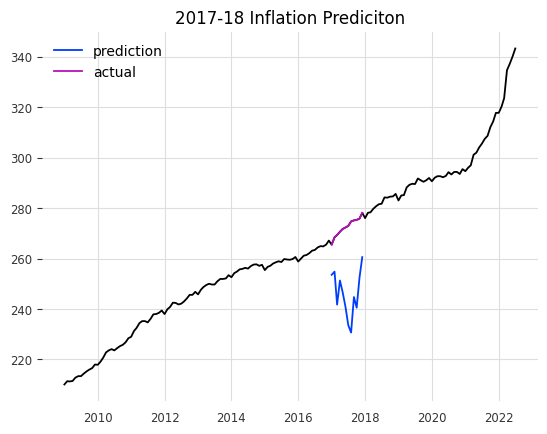

In [25]:
import matplotlib.pyplot as plt

plt.plot(y)
plt.plot(test_results['test_predictions'], label='prediction')
plt.plot(test_results['test_actual'], label='actual')
plt.title('2017-18 Inflation Prediciton')
plt.legend()
#plt.savefig('LSTM_new')



# LSTM 2018-2019

In [26]:
X_train1, y_train1 = X[:84], y[:84]
X_val1, y_val1 = X[84:108], y[84:108]
X_test1, y_test1 = X[108:120], y[108:120]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((84, 11), (84,), (24, 11), (24,), (12, 11), (12,))

In [27]:
y_train1_x = expand_dims(y_train1, -1)
y_train1_x = expand_dims(y_train1_x, -1)

y_train1_x.shape

TensorShape([84, 1, 1])

In [28]:
y_val1_x = expand_dims(y_val1, -1)
y_val1_x = expand_dims(y_val1_x, -1)

In [29]:
X_test1_x = expand_dims(X_test1, -2)

In [30]:
X_train1_x = expand_dims(X_train1, -2)
X_train1_x.shape

TensorShape([84, 1, 11])

In [31]:
X_val1_x = expand_dims(X_val1, -2)
X_val1_x.shape

TensorShape([24, 1, 11])

In [32]:
lr_scheduler = ExponentialDecay(initial_learning_rate=0.001, decay_steps= 10_000, decay_rate=0.7)
adam = Adam(learning_rate=lr_scheduler)
es = EarlyStopping(patience=50, restore_best_weights=True)

In [33]:
normalizer = Normalization()
normalizer.adapt(X_train1_x)

model2 = Sequential()
model2.add(normalizer)

model2.add(LSTM(units = 100, activation='tanh', return_sequences = True))
model2.add(LSTM(units = 50 , activation='tanh', return_sequences = False))

model2.add(Flatten())

model2.add(Dense(100,activation =  'relu'))
model2.add(Dense(50,activation =  'relu'))
model2.add(Dense(25,activation =  'relu'))

model2.add(Dense(1, activation = 'linear'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, None, 11)         23        
 ion)                                                            
                                                                 
 lstm_2 (LSTM)               (None, None, 100)         44800     
                                                                 
 lstm_3 (LSTM)               (None, 50)                30200     
                                                                 
 flatten_1 (Flatten)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 100)               5100      
                                                                 
 dense_5 (Dense)             (None, 50)                5050      
                                                      

In [34]:
model2.compile(loss= mape, optimizer= adam, metrics=['mape'])

In [35]:
model2.fit(X_train1_x, y_train1,batch_size = 32, validation_data=(X_val1_x, y_val1), epochs=10000, callbacks = (es))

Epoch 1/10000
3/3 [==============================] - 3s 273ms/step - loss: 99.9963 - mape: 99.9963 - val_loss: 99.9839 - val_mape: 99.9839
Epoch 2/10000
3/3 [==============================] - 0s 25ms/step - loss: 99.9816 - mape: 99.9816 - val_loss: 99.9637 - val_mape: 99.9637
Epoch 3/10000
3/3 [==============================] - 0s 25ms/step - loss: 99.9622 - mape: 99.9622 - val_loss: 99.9376 - val_mape: 99.9376
Epoch 4/10000
3/3 [==============================] - 0s 30ms/step - loss: 99.9371 - mape: 99.9371 - val_loss: 99.9033 - val_mape: 99.9033
Epoch 5/10000
3/3 [==============================] - 0s 28ms/step - loss: 99.9049 - mape: 99.9049 - val_loss: 99.8549 - val_mape: 99.8549
Epoch 6/10000
3/3 [==============================] - 0s 21ms/step - loss: 99.8613 - mape: 99.8613 - val_loss: 99.7886 - val_mape: 99.7886
Epoch 7/10000
3/3 [==============================] - 0s 26ms/step - loss: 99.8044 - mape: 99.8044 - val_loss: 99.6970 - val_mape: 99.6970
Epoch 8/10000
3/3 [==============

3/3 [==============================] - 0s 24ms/step - loss: 3.0694 - mape: 3.0694 - val_loss: 10.0266 - val_mape: 10.0266
Epoch 61/10000
3/3 [==============================] - 0s 23ms/step - loss: 2.8913 - mape: 2.8913 - val_loss: 9.6910 - val_mape: 9.6910
Epoch 62/10000
3/3 [==============================] - 0s 22ms/step - loss: 2.7608 - mape: 2.7608 - val_loss: 8.8875 - val_mape: 8.8875
Epoch 63/10000
3/3 [==============================] - 0s 23ms/step - loss: 2.6281 - mape: 2.6281 - val_loss: 8.5381 - val_mape: 8.5381
Epoch 64/10000
3/3 [==============================] - 0s 21ms/step - loss: 2.4111 - mape: 2.4111 - val_loss: 9.2835 - val_mape: 9.2835
Epoch 65/10000
3/3 [==============================] - 0s 23ms/step - loss: 2.3473 - mape: 2.3473 - val_loss: 8.7096 - val_mape: 8.7096
Epoch 66/10000
3/3 [==============================] - 0s 25ms/step - loss: 2.2077 - mape: 2.2077 - val_loss: 8.0549 - val_mape: 8.0549
Epoch 67/10000
3/3 [==============================] - 0s 23ms/step -

In [36]:
test_prediction1 = list(model2.predict(X_test1_x))

1/1 [==============================] - 1s 583ms/step


In [37]:
test_results1 = pd.DataFrame(columns = ['test_predictions', 'test_actual'])

#train_predictions

test_results1['date'] = list(y_test1.index)
test_results1['test_predictions'] = [x[0] for x in test_prediction1]
test_results1['test_actual'] = list(y_test1)

In [38]:
test_results1

,test_predictions,test_actual,date
0,294.537445,276.0,2018-01-01
1,288.867493,278.1,2018-02-01
2,288.048523,278.3,2018-03-01
3,290.683624,279.7,2018-04-01
4,293.845734,280.7,2018-05-01
5,293.316010,281.5,2018-06-01
6,294.218353,281.7,2018-07-01
7,293.934204,284.2,2018-08-01
8,294.422760,284.1,2018-09-01
9,290.392944,284.5,2018-10-01


In [39]:
test_results1.set_index('date', inplace=True)

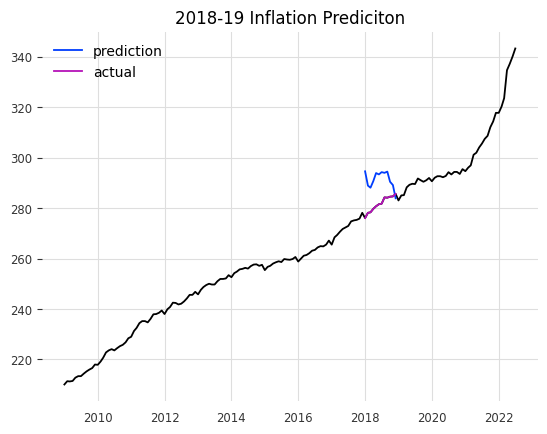

In [40]:
plt.plot(y)
plt.plot(test_results1['test_predictions'], label='prediction')
plt.plot(test_results1['test_actual'], label='actual')
plt.title('2018-19 Inflation Prediciton')
plt.legend()

# LSTM 2019-2020

In [41]:
X_train2, y_train2 = X[:96], y[:96]
X_val2, y_val2 = X[96:120], y[96:120]
X_test2, y_test2 = X[120:132], y[120:132]
X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

((96, 11), (96,), (24, 11), (24,), (12, 11), (12,))

In [42]:
y_train2_x = expand_dims(y_train2, -1)
y_train2_x = expand_dims(y_train2_x, -1)

y_train2_x.shape

TensorShape([96, 1, 1])

In [43]:
y_val2_x = expand_dims(y_val2, -1)
y_val2_x = expand_dims(y_val2_x, -1)

In [44]:
X_test2_x = expand_dims(X_test2, -2)

In [45]:
X_train2_x = expand_dims(X_train2, -2)
X_train2_x.shape

TensorShape([96, 1, 11])

In [46]:
X_val2_x = expand_dims(X_val2, -2)
X_val2_x.shape

TensorShape([24, 1, 11])

In [47]:
normalizer = Normalization()
normalizer.adapt(X_train2_x)

model3 = Sequential()
model3.add(normalizer)

model3.add(LSTM(units = 100, activation='tanh', return_sequences = True))
model3.add(LSTM(units = 50 , activation='tanh', return_sequences = False))

model3.add(Flatten())

model3.add(Dense(100,activation =  'relu'))
model3.add(Dense(50,activation =  'relu'))
model3.add(Dense(25,activation =  'relu'))

model3.add(Dense(1, activation = 'linear'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, None, 11)         23        
 ion)                                                            
                                                                 
 lstm_4 (LSTM)               (None, None, 100)         44800     
                                                                 
 lstm_5 (LSTM)               (None, 50)                30200     
                                                                 
 flatten_2 (Flatten)         (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None, 100)               5100      
                                                                 
 dense_9 (Dense)             (None, 50)                5050      
                                                      

In [48]:
model3.compile(loss= mape, optimizer= adam, metrics=['mape'])

In [49]:
model3.fit(X_train2_x, y_train2,batch_size = 32, validation_data=(X_val2_x, y_val2), epochs=10000, callbacks = (es))

Epoch 1/10000
3/3 [==============================] - 2s 272ms/step - loss: 99.9905 - mape: 99.9905 - val_loss: 99.9719 - val_mape: 99.9719
Epoch 2/10000
3/3 [==============================] - 0s 26ms/step - loss: 99.9488 - mape: 99.9488 - val_loss: 99.9083 - val_mape: 99.9083
Epoch 3/10000
3/3 [==============================] - 0s 28ms/step - loss: 99.8561 - mape: 99.8561 - val_loss: 99.7680 - val_mape: 99.7680
Epoch 4/10000
3/3 [==============================] - 0s 24ms/step - loss: 99.6662 - mape: 99.6662 - val_loss: 99.4938 - val_mape: 99.4938
Epoch 5/10000
3/3 [==============================] - 0s 22ms/step - loss: 99.2665 - mape: 99.2665 - val_loss: 98.9770 - val_mape: 98.9770
Epoch 6/10000
3/3 [==============================] - 0s 21ms/step - loss: 98.4455 - mape: 98.4455 - val_loss: 98.0620 - val_mape: 98.0620
Epoch 7/10000
3/3 [==============================] - 0s 25ms/step - loss: 96.8447 - mape: 96.8447 - val_loss: 96.5891 - val_mape: 96.5891
Epoch 8/10000
3/3 [==============

3/3 [==============================] - 0s 19ms/step - loss: 1.1869 - mape: 1.1869 - val_loss: 3.5442 - val_mape: 3.5442
Epoch 62/10000
3/3 [==============================] - 0s 19ms/step - loss: 1.0922 - mape: 1.0922 - val_loss: 4.1701 - val_mape: 4.1701
Epoch 63/10000
3/3 [==============================] - 0s 21ms/step - loss: 1.0943 - mape: 1.0943 - val_loss: 3.8712 - val_mape: 3.8712
Epoch 64/10000
3/3 [==============================] - 0s 19ms/step - loss: 1.1214 - mape: 1.1214 - val_loss: 3.9160 - val_mape: 3.9160
Epoch 65/10000
3/3 [==============================] - 0s 20ms/step - loss: 1.0371 - mape: 1.0371 - val_loss: 3.7738 - val_mape: 3.7738
Epoch 66/10000
3/3 [==============================] - 0s 20ms/step - loss: 1.0561 - mape: 1.0561 - val_loss: 4.0329 - val_mape: 4.0329
Epoch 67/10000
3/3 [==============================] - 0s 21ms/step - loss: 1.0091 - mape: 1.0091 - val_loss: 3.5755 - val_mape: 3.5755
Epoch 68/10000
3/3 [==============================] - 0s 20ms/step - l

In [50]:
test_prediction2 = list(model3.predict(X_test2_x))


1/1 [==============================] - 1s 570ms/step


In [51]:
test_results2 = pd.DataFrame(columns = ['test_predictions', 'test_actual'])

#train_predictions

test_results2['date'] = list(y_test2.index)
test_results2['test_predictions'] = [x[0] for x in test_prediction2]
test_results2['test_actual'] = list(y[120:132])

In [52]:
test_results2.set_index('date', inplace=True)

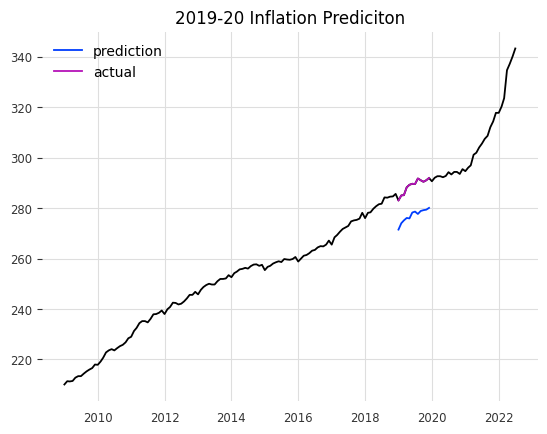

In [53]:
plt.plot(y)
plt.plot(test_results2['test_predictions'], label='prediction')
plt.plot(test_results2['test_actual'], label='actual')
plt.title('2019-20 Inflation Prediciton')
plt.legend()
#plt.savefig('LSTM_2019-20')

# LSTM 2020-2021

In [54]:
X[132:144]

,Brent_Crude_GBP,WTI_Crude_GBP,GBP Curncy,GBPEUR Curncy,UKX Index,SPX Index,SX5E Index,Natural_Gas,GBP_IRS_2y,GBP_IRS_10y,Nationwide_HPI
Date,,,,,,,,,,,
2020-01-01,49.021977,37.434634,1.298861,1.160843,7036.697727,2497.268828,3060.333106,7.781994,0.692330,0.710236,430.7
2020-02-01,42.943990,35.965277,1.291857,1.164014,6796.644286,2501.024605,3019.880708,7.418630,0.683318,0.645300,431.1
2020-03-01,27.211757,25.801736,1.239504,1.111822,5813.382174,2243.053117,2631.283557,6.975790,0.496927,0.614401,438.0
2020-04-01,21.072957,17.991584,1.263773,1.139632,6002.315714,2370.656764,2666.200693,5.995653,0.470125,0.524649,444.7
2020-05-01,25.990237,28.047836,1.247080,1.123495,6134.460000,2450.288506,2722.792714,4.950512,0.327838,0.459777,436.7
2020-06-01,32.338286,31.462164,1.260819,1.118319,6267.593333,2475.319143,2906.093329,5.429804,0.243187,0.453932,431.7
2020-07-01,33.762927,31.986664,1.280167,1.112688,6244.110000,2520.160305,2990.676103,5.291466,0.139427,0.406336,440.7
2020-08-01,34.536521,31.706150,1.303548,1.117148,6163.494211,2569.477068,2952.475053,6.921193,0.104939,0.457958,447.1
2020-09-01,32.488230,30.814480,1.288886,1.106245,6078.599545,2558.413712,2949.601847,8.556717,0.066389,0.432595,451.1


In [55]:
X_train3, y_train3 = X[:108], y[:108]
X_val3, y_val3 = X[108:132], y[108:132]
X_test3, y_test3 = X[132:144], y[132:144]
X_train3.shape, y_train3.shape, X_val3.shape, y_val3.shape, X_test3.shape, y_test3.shape

((108, 11), (108,), (24, 11), (24,), (12, 11), (12,))

In [56]:
y_train3_x = expand_dims(y_train3, -1)
y_train3_x = expand_dims(y_train3_x, -1)

y_train3_x.shape

TensorShape([108, 1, 1])

In [57]:
y_val3_x = expand_dims(y_val3, -1)
y_val3_x = expand_dims(y_val3_x, -1)

In [58]:
X_test3_x = expand_dims(X_test3, -2)

In [59]:
X_train3_x = expand_dims(X_train3, -2)
X_train3_x.shape

TensorShape([108, 1, 11])

In [60]:
X_val3_x = expand_dims(X_val3, -2)
X_val3_x.shape

TensorShape([24, 1, 11])

In [61]:
normalizer = Normalization()
normalizer.adapt(X_train3_x)

model4 = Sequential()
model4.add(normalizer)

model4.add(LSTM(units = 100, activation='tanh', return_sequences = True))
model4.add(LSTM(units = 50 , activation='tanh', return_sequences = False))

model4.add(Flatten())

model4.add(Dense(100,activation =  'relu'))
model4.add(Dense(50,activation =  'relu'))
model4.add(Dense(25,activation =  'relu'))

model4.add(Dense(1, activation = 'linear'))

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, None, 11)         23        
 ion)                                                            
                                                                 
 lstm_6 (LSTM)               (None, None, 100)         44800     
                                                                 
 lstm_7 (LSTM)               (None, 50)                30200     
                                                                 
 flatten_3 (Flatten)         (None, 50)                0         
                                                                 
 dense_12 (Dense)            (None, 100)               5100      
                                                                 
 dense_13 (Dense)            (None, 50)                5050      
                                                      

In [62]:
model4.compile(loss= mape, optimizer= adam, metrics=['mape'])

In [63]:
model4.fit(X_train3_x, y_train3,batch_size = 32, validation_data=(X_val3_x, y_val3), epochs=10000, callbacks = (es))

Epoch 1/10000
4/4 [==============================] - 3s 188ms/step - loss: 99.9804 - mape: 99.9804 - val_loss: 99.9061 - val_mape: 99.9061
Epoch 2/10000
4/4 [==============================] - 0s 20ms/step - loss: 99.8454 - mape: 99.8454 - val_loss: 99.5935 - val_mape: 99.5935
Epoch 3/10000
4/4 [==============================] - 0s 18ms/step - loss: 99.4253 - mape: 99.4253 - val_loss: 98.5124 - val_mape: 98.5124
Epoch 4/10000
4/4 [==============================] - 0s 17ms/step - loss: 98.1158 - mape: 98.1158 - val_loss: 95.3143 - val_mape: 95.3143
Epoch 5/10000
4/4 [==============================] - 0s 17ms/step - loss: 94.5088 - mape: 94.5088 - val_loss: 87.1796 - val_mape: 87.1796
Epoch 6/10000
4/4 [==============================] - 0s 18ms/step - loss: 85.7158 - mape: 85.7158 - val_loss: 70.3476 - val_mape: 70.3476
Epoch 7/10000
4/4 [==============================] - 0s 19ms/step - loss: 66.9014 - mape: 66.9014 - val_loss: 40.8455 - val_mape: 40.8455
Epoch 8/10000
4/4 [==============

4/4 [==============================] - 0s 18ms/step - loss: 1.0126 - mape: 1.0126 - val_loss: 6.4986 - val_mape: 6.4986
Epoch 62/10000
4/4 [==============================] - 0s 17ms/step - loss: 1.1679 - mape: 1.1679 - val_loss: 6.5701 - val_mape: 6.5701
Epoch 63/10000
4/4 [==============================] - 0s 19ms/step - loss: 0.9530 - mape: 0.9530 - val_loss: 5.3870 - val_mape: 5.3870


In [64]:
test_prediction3 = list(model4.predict(X_test3_x))


1/1 [==============================] - 0s 486ms/step


In [65]:
test_results3 = pd.DataFrame(columns = ['test_predictions', 'test_actual'])

#train_predictions

test_results3['date'] = list(y_test3.index)
test_results3['test_predictions'] = [x[0] for x in test_prediction3]
test_results3['test_actual'] = list(y_test3)

In [66]:
test_results3.set_index('date', inplace=True)

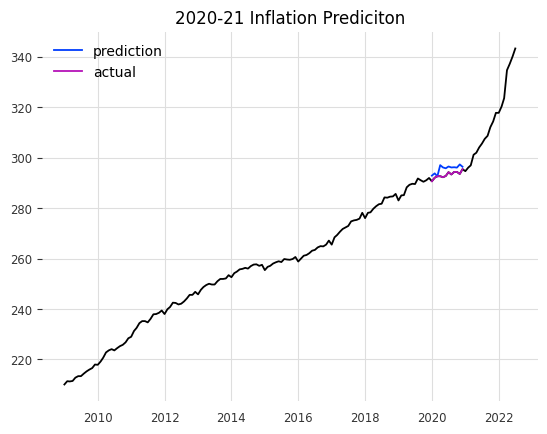

In [67]:
plt.plot(y)
plt.plot(test_results3['test_predictions'], label='prediction')
plt.plot(test_results3['test_actual'], label='actual')
plt.title('2020-21 Inflation Prediciton')
plt.legend()
plt.savefig('LSTM_2020-21')

# LSTM 2021-2022

In [68]:
X[:165]

,Brent_Crude_GBP,WTI_Crude_GBP,GBP Curncy,GBPEUR Curncy,UKX Index,SPX Index,SX5E Index,Natural_Gas,GBP_IRS_2y,GBP_IRS_10y,Nationwide_HPI
Date,,,,,,,,,,,
2009-01-01,30.903838,33.424333,1.479027,1.099905,4308.390000,596.071497,2135.982324,12.472805,2.122545,3.757500,300.2
2009-02-01,29.393166,33.617553,1.492643,1.120824,4232.114762,570.410394,2020.716905,9.467866,2.129905,3.798333,294.7
2009-03-01,31.733352,36.826152,1.494241,1.097877,4107.840909,566.393975,2029.160819,8.064295,2.142045,3.872500,301.1
2009-04-01,33.990786,36.012519,1.511936,1.125327,4259.890500,588.042125,2119.383029,7.762397,2.143250,3.935500,302.9
2009-05-01,37.524515,38.801542,1.561252,1.131686,4434.719500,582.718727,2164.120107,7.757394,2.031900,3.917500,307.2
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-01,89.748267,85.128666,1.247484,1.178074,7472.767778,3274.256696,3179.554466,81.073170,2.538121,2.240542,538.4
2022-06-01,95.251442,87.836565,1.233611,1.167758,7238.188421,3172.340166,3058.969505,96.746393,2.933563,2.626558,541.8
2022-07-01,85.363871,80.415504,1.231479,1.184589,7303.865263,3298.689210,3082.959231,128.688654,2.700779,2.302258,541.0


In [69]:
X_train4, y_train4 = X[:132], y[:132]
X_val4, y_val4 = X[132:156], y[132:156]
X_test4, y_test4 = X[156:165], y[156:165]
X_train4.shape, y_train4.shape, X_val4.shape, y_val4.shape, X_test4.shape, y_test4.shape

((132, 11), (132,), (24, 11), (24,), (9, 11), (9,))

In [70]:
y_train4_x = expand_dims(y_train4, -1)
y_train4_x = expand_dims(y_train4_x, -1)

y_train4_x.shape

TensorShape([132, 1, 1])

In [71]:
y_val4_x = expand_dims(y_val4, -1)
y_val4_x = expand_dims(y_val4_x, -1)

In [72]:
X_test4_x = expand_dims(X_test4, -2)

In [73]:
X_train4_x = expand_dims(X_train4, -2)
X_train4_x.shape

TensorShape([132, 1, 11])

In [74]:
X_val4_x = expand_dims(X_val4, -2)
X_val4_x.shape

TensorShape([24, 1, 11])

In [75]:
normalizer = Normalization()
normalizer.adapt(X_train4_x)

model5 = Sequential()
model5.add(normalizer)

model5.add(LSTM(units = 100, activation='tanh', return_sequences = True))
model5.add(LSTM(units = 50 , activation='tanh', return_sequences = False))

model5.add(Flatten())

model5.add(Dense(100,activation =  'relu'))
model5.add(Dense(50,activation =  'relu'))
model5.add(Dense(25,activation =  'relu'))

model5.add(Dense(1, activation = 'linear'))

model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, None, 11)         23        
 ion)                                                            
                                                                 
 lstm_8 (LSTM)               (None, None, 100)         44800     
                                                                 
 lstm_9 (LSTM)               (None, 50)                30200     
                                                                 
 flatten_4 (Flatten)         (None, 50)                0         
                                                                 
 dense_16 (Dense)            (None, 100)               5100      
                                                                 
 dense_17 (Dense)            (None, 50)                5050      
                                                      

In [76]:
model5.compile(loss= mape, optimizer= adam, metrics=['mape'])

In [77]:
model5.fit(X_train4_x, y_train4,batch_size = 32, validation_data=(X_val4_x, y_val4), epochs=10000, callbacks = (es))

Epoch 1/10000
5/5 [==============================] - 3s 169ms/step - loss: 99.9724 - mape: 99.9724 - val_loss: 99.8834 - val_mape: 99.8834
Epoch 2/10000
5/5 [==============================] - 0s 17ms/step - loss: 99.7049 - mape: 99.7049 - val_loss: 99.3500 - val_mape: 99.3500
Epoch 3/10000
5/5 [==============================] - 0s 17ms/step - loss: 98.3905 - mape: 98.3905 - val_loss: 97.3061 - val_mape: 97.3061
Epoch 4/10000
5/5 [==============================] - 0s 17ms/step - loss: 92.8597 - mape: 92.8597 - val_loss: 91.5419 - val_mape: 91.5419
Epoch 5/10000
5/5 [==============================] - 0s 17ms/step - loss: 76.5475 - mape: 76.5475 - val_loss: 79.3488 - val_mape: 79.3488
Epoch 6/10000
5/5 [==============================] - 0s 16ms/step - loss: 47.3742 - mape: 47.3742 - val_loss: 54.1454 - val_mape: 54.1454
Epoch 7/10000
5/5 [==============================] - 0s 16ms/step - loss: 41.3957 - mape: 41.3957 - val_loss: 12.7081 - val_mape: 12.7081
Epoch 8/10000
5/5 [==============

5/5 [==============================] - 0s 20ms/step - loss: 0.9229 - mape: 0.9229 - val_loss: 3.8171 - val_mape: 3.8171
Epoch 62/10000
5/5 [==============================] - 0s 18ms/step - loss: 1.0171 - mape: 1.0171 - val_loss: 4.3317 - val_mape: 4.3317
Epoch 63/10000
5/5 [==============================] - 0s 17ms/step - loss: 0.9715 - mape: 0.9715 - val_loss: 3.8719 - val_mape: 3.8719
Epoch 64/10000
5/5 [==============================] - 0s 16ms/step - loss: 1.0953 - mape: 1.0953 - val_loss: 4.6021 - val_mape: 4.6021
Epoch 65/10000
5/5 [==============================] - 0s 15ms/step - loss: 0.9894 - mape: 0.9894 - val_loss: 4.0491 - val_mape: 4.0491


In [78]:
test_prediction4 = list(model5.predict(X_test4_x))
test_prediction4


2022-09-13 15:09:39 tensorflow WARNING: 5 out of the last 6 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7faac7e95310> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 1s 590ms/step


[array([119.62996], dtype=float32),
 array([203.55383], dtype=float32),
 array([237.39905], dtype=float32),
 array([235.8306], dtype=float32),
 array([239.38283], dtype=float32),
 array([241.57513], dtype=float32),
 array([242.18964], dtype=float32),
 array([240.72095], dtype=float32),
 array([4.28724], dtype=float32)]

In [79]:
test_results4 = pd.DataFrame(columns = ['test_predictions', 'test_actual'])

#train_predictions

test_results4['date'] = list(y_test4.index)
test_results4['test_predictions'] = [x[0] for x in test_prediction4]
test_results4['test_actual'] = list(y_test4)

In [80]:
test_results4.set_index('date', inplace=True)

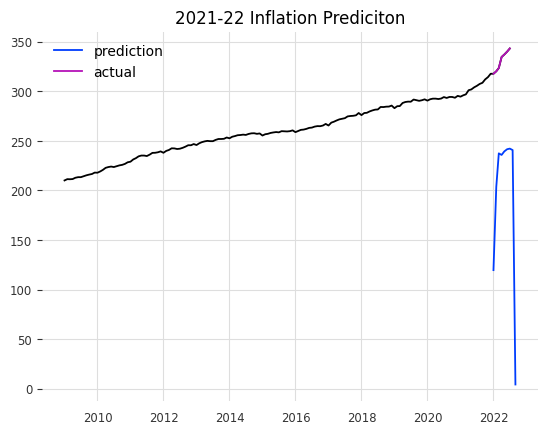

In [81]:
plt.plot(y)
plt.plot(test_results4['test_predictions'], label='prediction')
plt.plot(test_results4['test_actual'], label='actual')
plt.title('2021-22 Inflation Prediciton')
plt.legend()

# LSTM 2022-

In [82]:
X[159:165]

,Brent_Crude_GBP,WTI_Crude_GBP,GBP Curncy,GBPEUR Curncy,UKX Index,SPX Index,SX5E Index,Natural_Gas,GBP_IRS_2y,GBP_IRS_10y,Nationwide_HPI
Date,,,,,,,,,,,
2022-04-01,82.294714,78.884404,1.287045,1.194540,7475.842222,3390.642475,3202.490777,86.613133,2.365979,2.085100,533.9
2022-05-01,89.748267,85.128666,1.247484,1.178074,7472.767778,3274.256696,3179.554466,81.073170,2.538121,2.240542,538.4
2022-06-01,95.251442,87.836565,1.233611,1.167758,7238.188421,3172.340166,3058.969505,96.746393,2.933563,2.626558,541.8
2022-07-01,85.363871,80.415504,1.231479,1.184589,7303.865263,3298.689210,3082.959231,128.688654,2.700779,2.302258,541.0
2022-08-01,80.656541,78.913331,1.211816,1.181732,7453.987222,3446.779300,3131.457852,180.082147,3.368889,2.688500,546.1
2022-09-01,73.474167,80.706056,1.272420,1.180400,7403.016000,3300.260920,3208.537784,93.341821,2.475340,2.155940,NaN


In [83]:
X_train5, y_train5 = X[:156], y[:156]
X_val5, y_val5 = X[156:163], y[156:163]
X_test5, y_test5 = X[163:164], y[163:164]
X_train5.shape, y_train5.shape, X_val5.shape, y_val5.shape, X_test5.shape, y_test5.shape

((156, 11), (156,), (7, 11), (7,), (1, 11), (1,))

In [84]:
y_train5_x = expand_dims(y_train5, -1)
y_train5_x = expand_dims(y_train5_x, -1)

y_train5_x.shape

TensorShape([156, 1, 1])

In [85]:
y_val5_x = expand_dims(y_val5, -1)
y_val5_x = expand_dims(y_val5_x, -1)

In [86]:
X_test5_x = expand_dims(X_test5, -2)

In [87]:
X_train5_x = expand_dims(X_train5, -2)
X_train5_x.shape

TensorShape([156, 1, 11])

In [88]:
X_val5_x = expand_dims(X_val5, -2)
X_val5_x.shape

TensorShape([7, 1, 11])

In [89]:
normalizer = Normalization()
normalizer.adapt(X_train5_x)

model6 = Sequential()
model6.add(normalizer)

model6.add(LSTM(units = 110, activation='tanh', return_sequences = True))
model6.add(LSTM(units = 50 , activation='tanh', return_sequences = False))

model6.add(Flatten())

model6.add(Dense(100,activation =  'relu'))
model6.add(Dense(50,activation =  'relu'))
model6.add(Dense(25,activation =  'relu'))
model6.add(Dense(25,activation =  'relu'))
model6.add(Dense(12,activation =  'relu'))




model6.add(Dense(1, activation = 'linear'))

model6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, None, 11)         23        
 ion)                                                            
                                                                 
 lstm_10 (LSTM)              (None, None, 110)         53680     
                                                                 
 lstm_11 (LSTM)              (None, 50)                32200     
                                                                 
 flatten_5 (Flatten)         (None, 50)                0         
                                                                 
 dense_20 (Dense)            (None, 100)               5100      
                                                                 
 dense_21 (Dense)            (None, 50)                5050      
                                                      

In [90]:
model6.compile(loss= mape, optimizer= adam, metrics=['mape'])

In [91]:
model6.fit(X_train5_x, y_train5, batch_size = 16, validation_data=(X_val5_x, y_val5), epochs=10000, callbacks = (es))

Epoch 1/10000
10/10 [==============================] - 3s 73ms/step - loss: 99.8190 - mape: 99.8190 - val_loss: 99.3561 - val_mape: 99.3561
Epoch 2/10000
10/10 [==============================] - 0s 14ms/step - loss: 93.1462 - mape: 93.1462 - val_loss: 86.3387 - val_mape: 86.3387
Epoch 3/10000
10/10 [==============================] - 0s 13ms/step - loss: 45.3656 - mape: 45.3656 - val_loss: 12.1782 - val_mape: 12.1782
Epoch 4/10000
10/10 [==============================] - 0s 13ms/step - loss: 16.4871 - mape: 16.4871 - val_loss: 14.6663 - val_mape: 14.6663
Epoch 5/10000
10/10 [==============================] - 0s 11ms/step - loss: 12.4742 - mape: 12.4742 - val_loss: 23.8497 - val_mape: 23.8497
Epoch 6/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.4765 - mape: 7.4765 - val_loss: 25.8768 - val_mape: 25.8768
Epoch 7/10000
10/10 [==============================] - 0s 11ms/step - loss: 6.3213 - mape: 6.3213 - val_loss: 16.5491 - val_mape: 16.5491
Epoch 8/10000
10/10 [===

10/10 [==============================] - 0s 12ms/step - loss: 0.7421 - mape: 0.7421 - val_loss: 8.8552 - val_mape: 8.8552
Epoch 61/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.6584 - mape: 0.6584 - val_loss: 9.2363 - val_mape: 9.2363
Epoch 62/10000
10/10 [==============================] - 0s 12ms/step - loss: 0.7600 - mape: 0.7600 - val_loss: 8.4143 - val_mape: 8.4143
Epoch 63/10000
10/10 [==============================] - 0s 12ms/step - loss: 1.0656 - mape: 1.0656 - val_loss: 8.3302 - val_mape: 8.3302
Epoch 64/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.1528 - mape: 1.1528 - val_loss: 10.6470 - val_mape: 10.6470
Epoch 65/10000
10/10 [==============================] - 0s 10ms/step - loss: 1.1076 - mape: 1.1076 - val_loss: 10.0345 - val_mape: 10.0345
Epoch 66/10000
10/10 [==============================] - 0s 9ms/step - loss: 0.7681 - mape: 0.7681 - val_loss: 11.4460 - val_mape: 11.4460
Epoch 67/10000
10/10 [=============================

In [92]:
test_prediction5 = list(model6.predict(X_test5_x))


2022-09-13 15:10:05 tensorflow WARNING: 6 out of the last 7 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7faac60ad430> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 1s 596ms/step


In [93]:
test_prediction5

[array([336.54977], dtype=float32)]

In [94]:
y_test5

Date
2022-08-01   NaN
Name: RPI, dtype: float64

In [95]:
# res = []
# for x in range(1):
#     val = pd.to_datetime(pd.DataFrame(y).iloc[-x,:0]).name
#     res.append(val)

In [96]:
# res = res[1:]

In [97]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [98]:
# list(y_test5[:-1])

In [99]:
# future_vals = []
# for x in res:
#     future_date = x + relativedelta(months=1)
#     future_vals.append(future_date)

In [100]:
# future_vals

In [101]:
test_results5 = pd.DataFrame(columns = ['test_predictions', 'test_actual'])

#train_predictions

test_results5['date'] = y_test5.index
test_results5['test_predictions'] = [x[0] for x in test_prediction5]
print(test_results5['date'])

0   2022-08-01
Name: date, dtype: datetime64[ns]


In [102]:
test_results5.set_index('date', inplace=True)

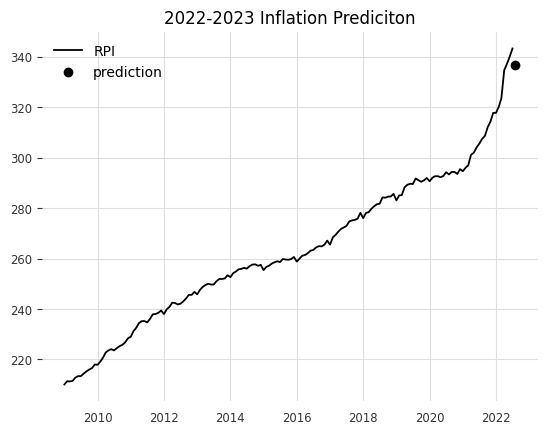

In [109]:
plt.plot(y, label='RPI')
plt.scatter([y_test5.index], test_results5['test_predictions'], label='prediction')
plt.title('2022-2023 Inflation Prediciton')
plt.legend()
#plt.savefig('LSTM_Pred_5th_run')

In [105]:
!pwd


/home/amirel/code/amirlewagon/time_series


In [106]:
model6.save('time_series_final_pred')

2022-09-13 15:10:25 absl WARNING: Found untraced functions such as lstm_cell_10_layer_call_fn, lstm_cell_10_layer_call_and_return_conditional_losses, lstm_cell_11_layer_call_fn, lstm_cell_11_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


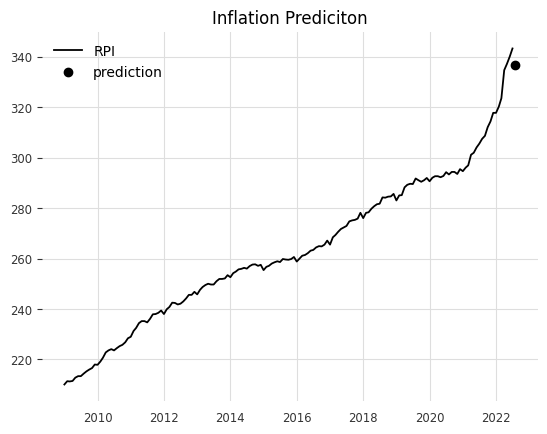

In [115]:
fig, ax = plt.subplots()
ax.plot(y, label = 'RPI')
ax.scatter([y_test5.index], test_results5['test_predictions'], label='prediction')
ax.set_title('Inflation Prediciton')
ax.legend()
fig.show()